# Handling bounded distributions

Many distributions have shark peaks at zero and a lower bound. We can improve modelling of such distributions with the `Unbounder` bijector. It is easier for neural spline couplings to model distributions which have the probability mass in the center of the domain than at the edges. The `Transform` bijector makes the distribution easier to learn.

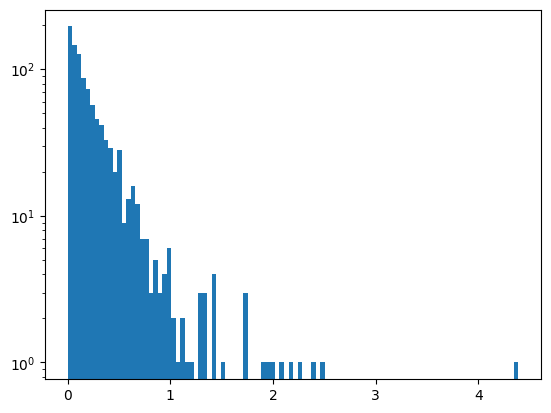

In [1]:
from zenflow import Flow, train
from zenflow import bijectors as bij
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(1)

# we must use at least 2D input, but we only care about the first dimension
X = np.column_stack([
    rng.pareto(5, size=1000),
    rng.uniform(size=1000),
])

plt.hist(X[:, 0], bins=100)
plt.semilogy();

The `margin` parameter in `rolling_spline_coupling` is important when learning this distribution. If it is too small, the training will fail. If it is too large, we get artifacts. To demonstrate this we set it to a large value of 0.1. Note: The artifacts can be made very small by setting `margin=1e-5`.

  0%|          | 0/1000 [00:00<?, ?it/s]

-0.2881239056587219


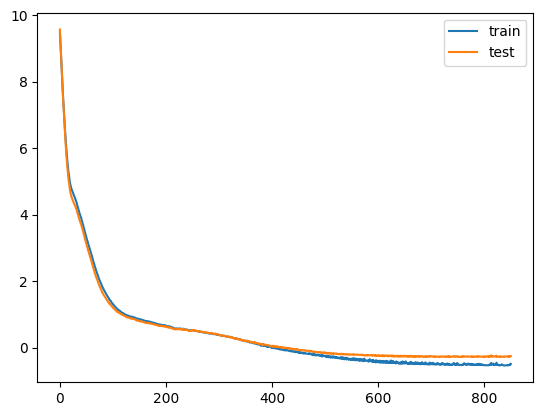

In [2]:
flow = Flow(bij.rolling_spline_coupling(2, margin=0.1))

X_train, X_test = train_test_split(X, random_state=1)

vars, best_epoch, loss_train, loss_test = train(flow, X_train, X_test)
print(loss_test[best_epoch])

plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend();

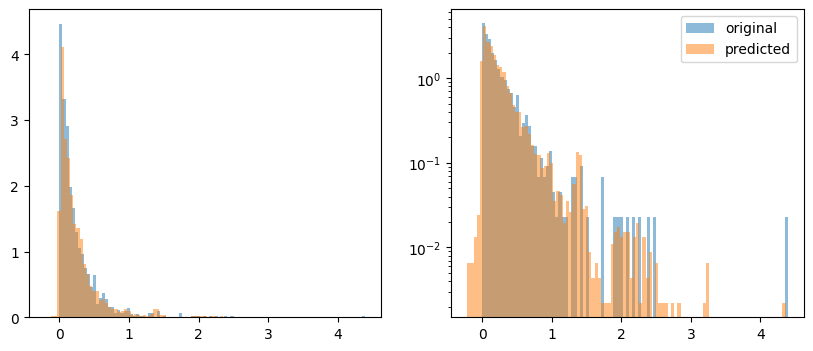

In [3]:
Xp = flow.apply(vars, 10000, method="sample")

def draw(x, xp):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(x[:, 0], bins=100, density=True, alpha=0.5, label="original")
    ax[0].hist(xp[:, 0], bins=100, density=True, alpha=0.5, label="predicted")
    ax[1].hist(x[:, 0], bins=100, density=True, alpha=0.5, label="original")
    ax[1].hist(xp[:, 0], bins=100, density=True, alpha=0.5, label="predicted")
    plt.semilogy()
    plt.legend()

draw(X, Xp)

This result looks ok in linear scale, but we see unwanted artifacts in logarithmic scale. Our model does not know that the domain of the Pareto distribution is strictly positive. We can fix this by learning of the transformed variable log(x), which looks more like a (skewed) normal distribution.

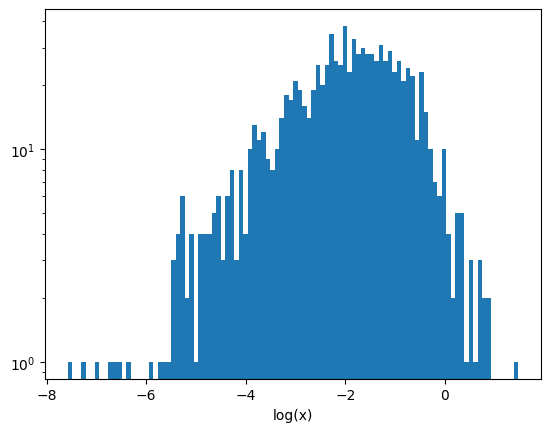

In [4]:
LX = np.column_stack([
    np.log(X[:, 0]),
    X[:, 1],
])

plt.hist(LX[:, 0], bins=100)
plt.semilogy()
plt.xlabel("log(x)");

  0%|          | 0/1000 [00:00<?, ?it/s]

1.8716565370559692


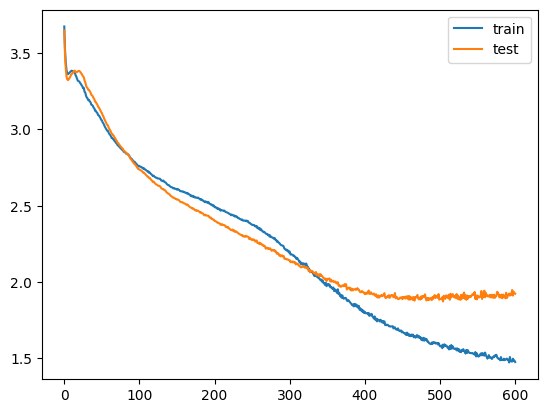

In [5]:
flow = Flow(bij.rolling_spline_coupling(2, margin=0.1))

rng = np.random.default_rng(1)

X_train, X_test = train_test_split(LX, random_state=1)

vars, best_epoch, loss_train, loss_test = train(flow, X_train, X_test)
print(loss_test[best_epoch])

plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend();

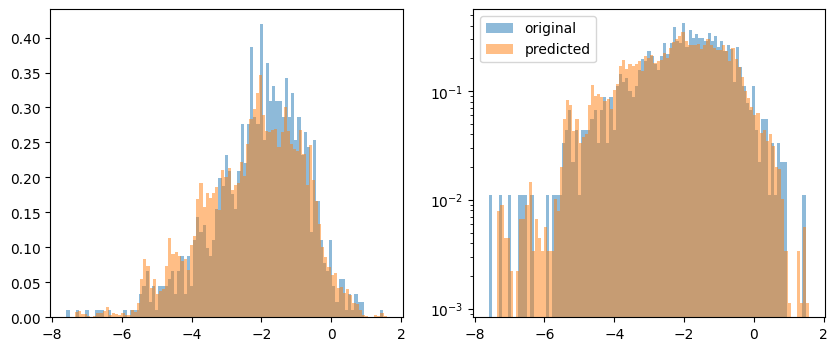

In [6]:
LXp = flow.apply(vars, 10000, method="sample")
draw(LX, LXp)

Even with the poorly chosen margin, we get a nice distribution in the back-transformed variable.

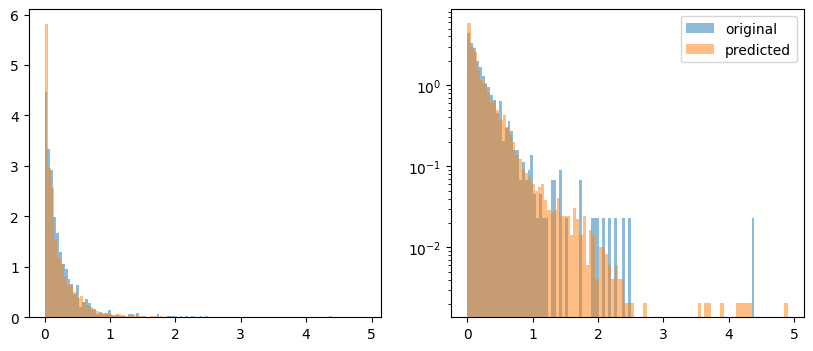

In [7]:
draw(X, np.exp(LXp))

This useful technique was added as an option to the `ShiftBounds` bijector. `rolling_spline_coupling` allows us to customize `ShiftBounds` with the `bounds` option. We use it to declare that our lower bound is 0 for the values in the first dimension. `ShiftBounds` will then apply the log-transform before doing usual its shifting and scaling.

  0%|          | 0/1000 [00:00<?, ?it/s]

-0.27302634716033936


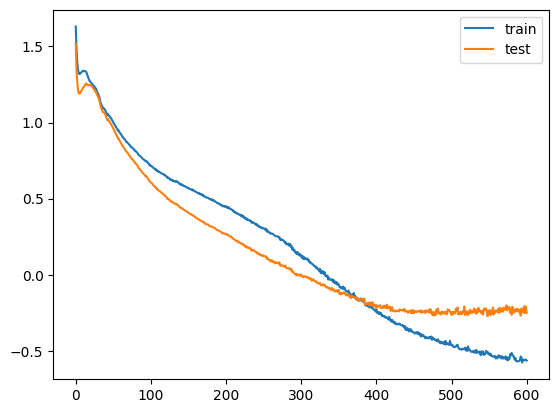

In [8]:
flow = Flow(bij.rolling_spline_coupling(2, margin=0.1, bounds=[(0, 0, None)]))

rng = np.random.default_rng(1)

X_train, X_test = train_test_split(X, random_state=1)

vars, best_epoch, loss_train, loss_test = train(flow, X_train, X_test)
print(loss_test[best_epoch])

plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend();

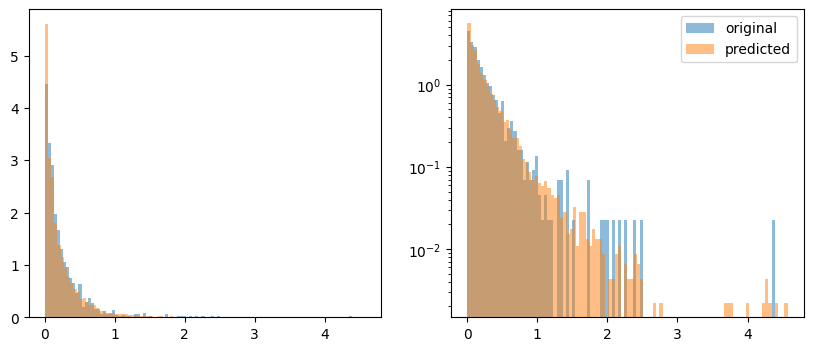

In [9]:
Xp = flow.apply(vars, 10000, method="sample")
draw(X, Xp)

The result looks very good despite the large value of `margin`.